In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Normalizes a dataframes integer columns
def normalize(df):
	copy = df.copy()
	for col in df.columns:
		if(df[col].dtypes == 'int64'):
			max = df[col].max()
			min = df[col].min()
			copy[col] = (df[col]-min)/(max - min)
	return copy


In [6]:
df = pd.read_csv('daveData/train.csv')
df = df.dropna()
df = df.drop(columns={'Unnamed: 0', 'id'})

hotdf = pd.get_dummies(df)
hotdf = hotdf.drop(columns={'satisfaction_neutral or dissatisfied'})

# Normalize our data because it's kinda cringe
hotdf = normalize(hotdf)
hotdf.head()


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,0.076923,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,...,0,1,1,0,0,1,0,0,1,0
1,0.230769,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,...,0,1,0,1,1,0,1,0,0,0
2,0.243590,0.224354,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,...,1,0,1,0,1,0,1,0,0,1
3,0.230769,0.107229,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,...,1,0,1,0,1,0,1,0,0,0
4,0.692308,0.036955,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,...,0,1,1,0,1,0,1,0,0,1


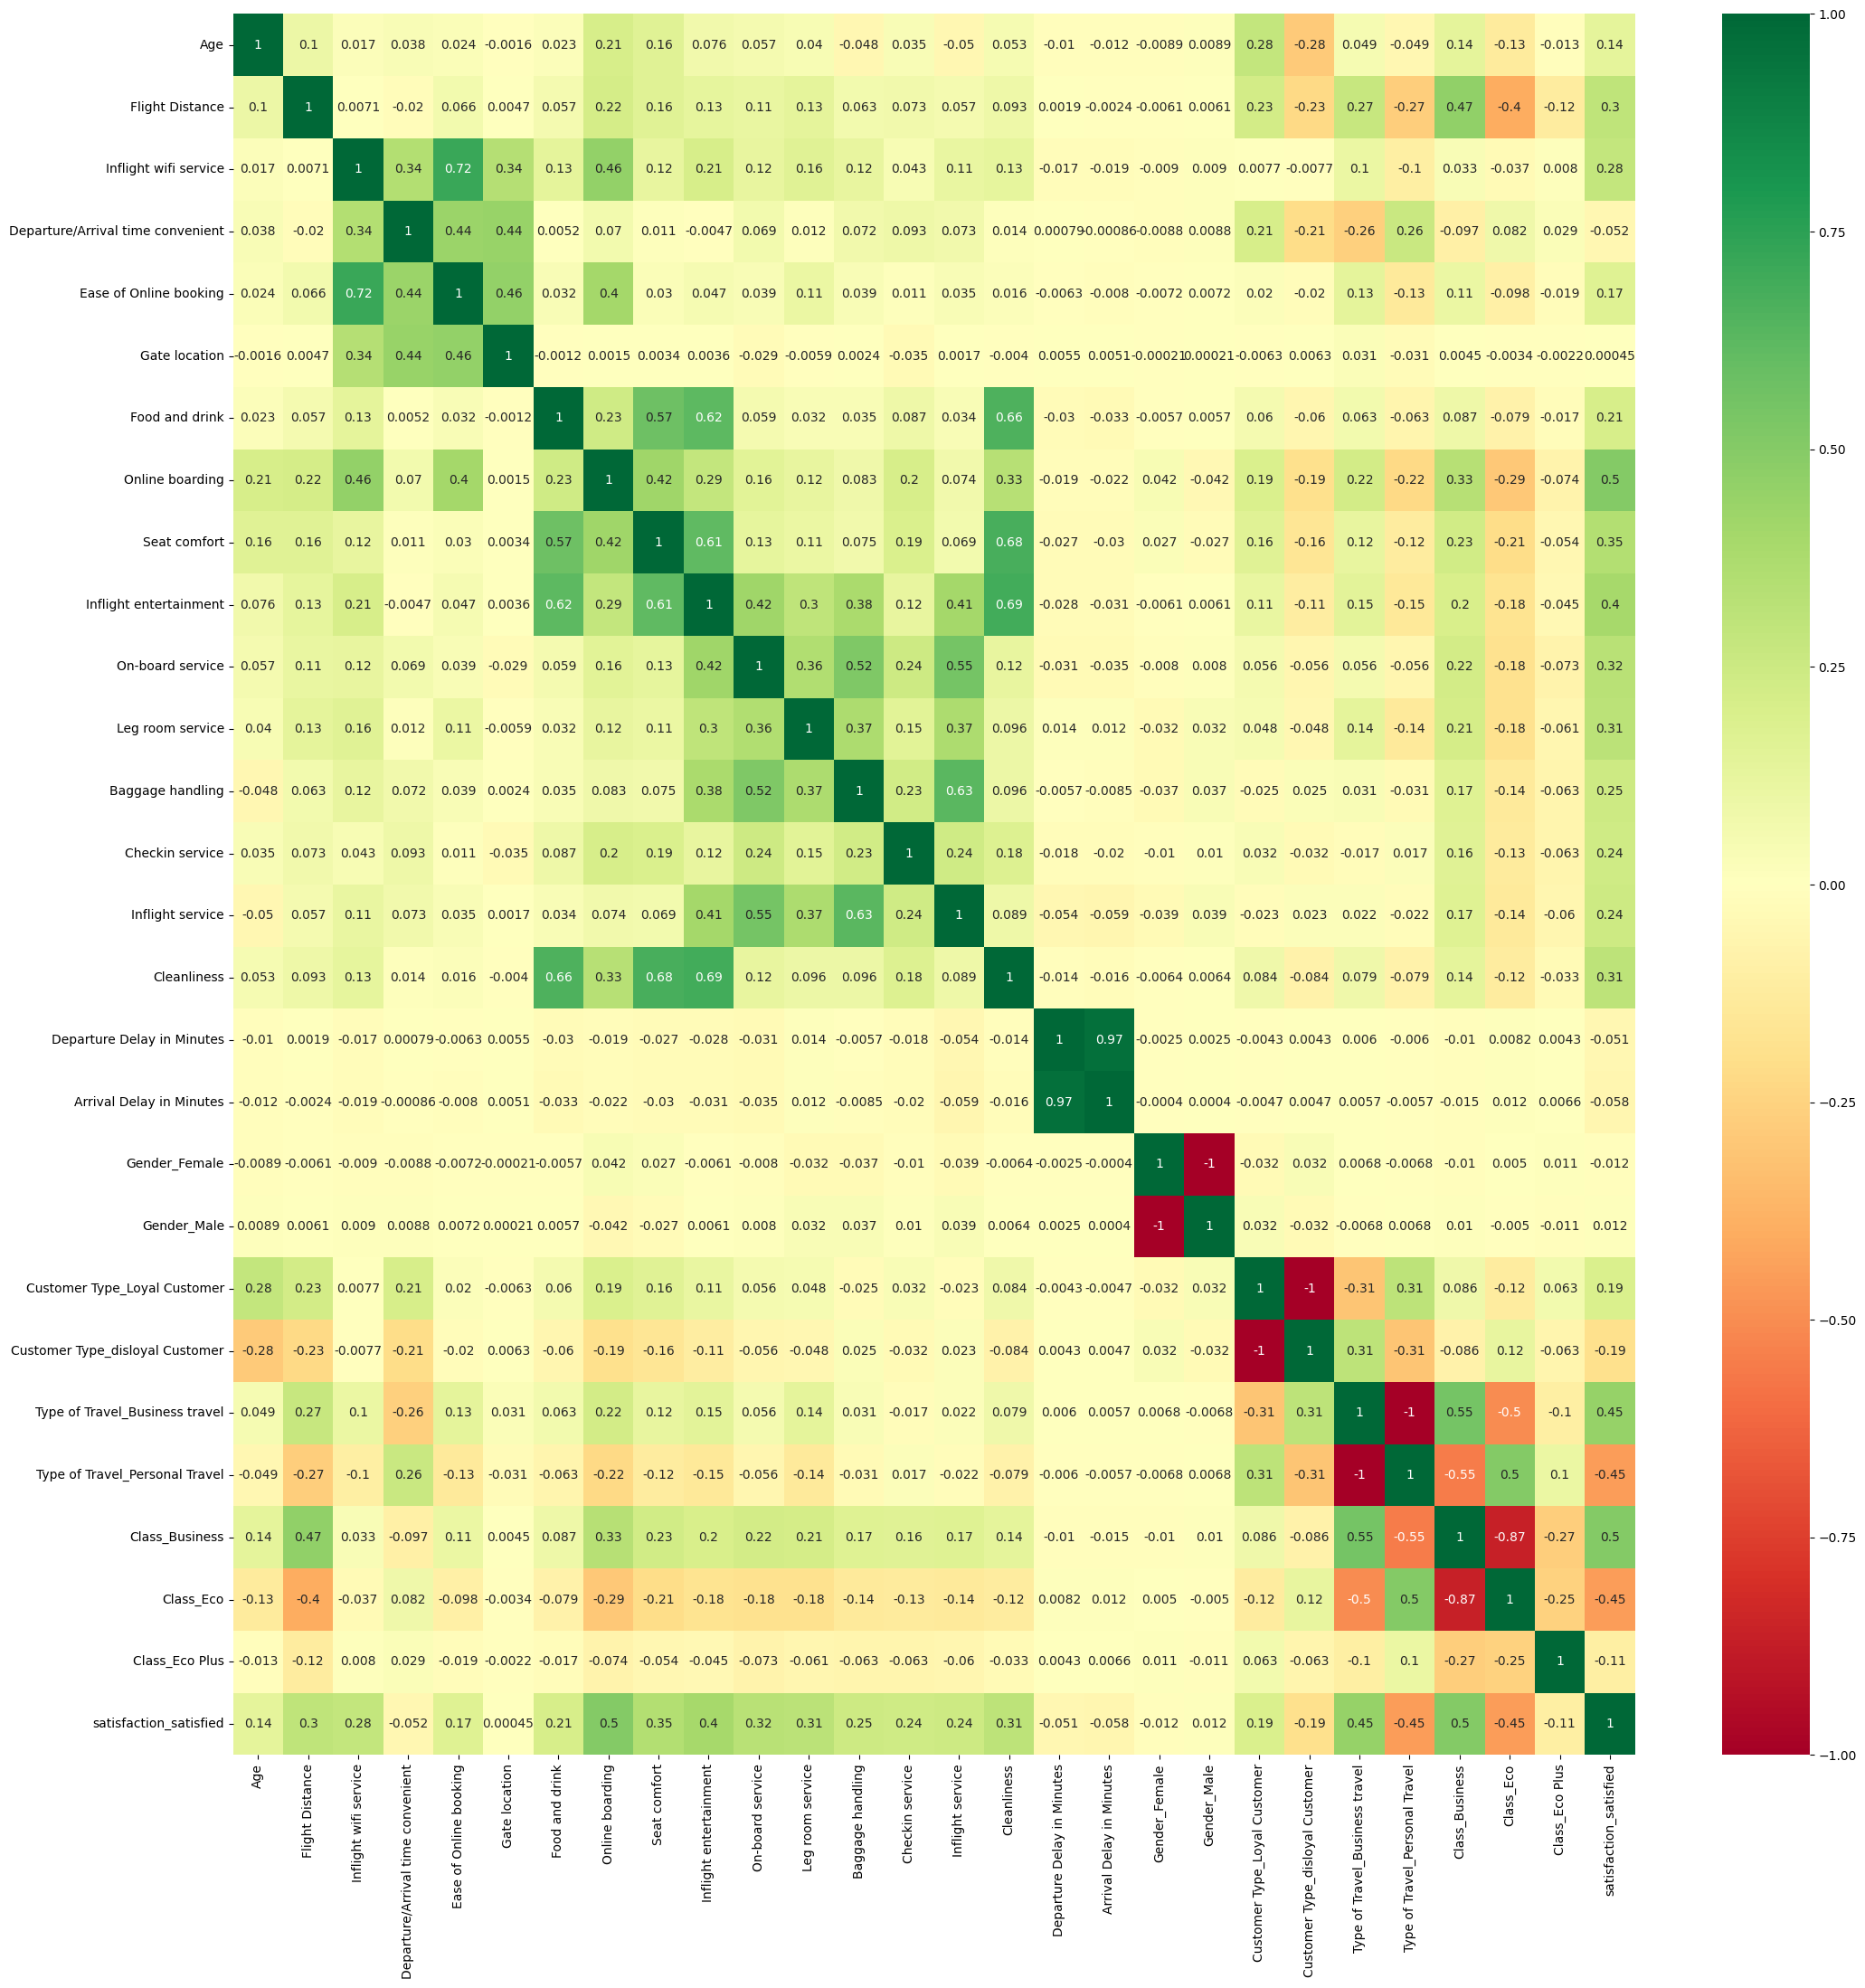

In [7]:

corr_matrix = hotdf.corr()
best_features = corr_matrix.index
plt.figure(figsize=(25,25))
hot = sns.heatmap(hotdf[best_features].corr(),annot=True,cmap="RdYlGn")


In [8]:
y = hotdf['satisfaction_satisfied']
x = hotdf[['Online boarding', 'Type of Travel_Business travel', 'Class_Business']].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

clf = svm.SVC(kernel='linear', class_weight={0:1})
clf.fit(x_train, y_train)
print("hi")
y_pred = clf.predict(x_test)

p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
display('precision = {}'.format(p))
display('recall = {}'.format(r))
display('f-score = {}'.format(f))

hi


'precision = [0.81972062 0.79997661]'

'recall = [0.85367106 0.75711281]'

'f-score = [0.83635144 0.77795473]'